<a href="https://colab.research.google.com/github/woodongk/news-comments_emotion_classification-CNN-tensorflow/blob/master/news-comments_emotion_classification-CNN-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
word2vec_model_path = "/content/drive/MyDrive/Dataset 및 Project 정리/daum news and comments (2016 - 2017)/word_embedding_model/word2vec300/0710 w2v_model"
data_path = "/content/drive/MyDrive/Dataset 및 Project 정리/daum news and comments (2016 - 2017)/final_data/comment_with_emo_over0.5.pkl"

In [3]:
import pandas as pd
import numpy as np
import pickle
import codecs
import time
from itertools import chain
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from gensim.models import word2vec
from gensim.models import FastText
from gensim.test.utils import get_tmpfile

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import sys
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.4.1'

# 데이터 준비하기 

## 감정 댓글 불러오기

In [5]:
emotion_comment_df = pd.read_pickle(data_path)
print("emotion_comment_df: ", emotion_comment_df.shape)
display(emotion_comment_df.sample(5))

emotion_comment_df:  (408607, 11)


,happy,sad,disgust,angry,surprised,fear,comment_id,comment,comment_token,check,emotion
1773495,0.0,0.0,0.0,1.0,0.0,0.0,B012F53CF9AB4956AB4C1D78EF282733,젊은 놈이 자유한국당 스러운 놈일세,"[젊다, 놈, 자유, 한국, 스럽다, 놈]","[놈, 놈]",angry
837539,0.0,0.0,0.0,1.0,0.0,0.0,531AC08B289A43279448AB08A13459FC,적폐 이철성이 얘가 아직도 버티고 있다는게 열받는다,"[적폐, 이철성, 얘, 아직도, 버티고, 있다, 열, 받다]",[적폐],angry
677656,0.0,0.0,1.0,0.0,0.0,0.0,BE113DAF9376498DBCC8A0516E429A45,고추로 된장 찍어먹는 넘들...... 똥꼬충들아 군대가 니들 안방이냐 아님 모텔이냐...,"[고추, 된장, 찍다, 먹다, 넘다, 들다, 똥꼬, 충, 군대, 니, 안방, 아니다...",[더럽다],disgust
891648,0.0,0.0,0.0,1.0,0.0,0.0,BD9CD0F4926D451C9C5A8DA06331DACA,대한민국은 미친나라? 여학생 말만 믿고 ㅈ선생님을 조사하고 처벌하는나라 다리를 떨면...,"[대한민국, 미치다, 여학생, 말, 믿다, 선생님, 조사, 처벌, 다리, 떨다, 복...",[미치다],angry
600962,0.0,0.0,0.0,1.0,0.0,0.0,8AB3FF9ED51A49CBB4BB45944DB6154D,때국넘들 진핑이 새끼가 ♩♩이네...,"[때국, 넘다, 들다, 진핑, 새끼]",[새끼],angry


In [6]:
print("샘플링 전 :",Counter(emotion_comment_df.emotion))
print()

# 각 감정별로 셔플한 다음 8,000개씩 부여 (Train = 85% / Test = 15%)
sample_count = 8000

sampled_emo_cmt_df = (
    emotion_comment_df.groupby('emotion').apply(
        lambda d: shuffle(d, random_state=42, n_samples=sample_count)).reset_index(drop=True)
)

print("샘플링 이후 :",Counter(sampled_emo_cmt_df.emotion))

샘플링 전 : Counter({'angry': 240971, 'sad': 83041, 'happy': 44682, 'disgust': 17263, 'fear': 14649, 'surprised': 8001})

샘플링 이후 : Counter({'angry': 8000, 'disgust': 8000, 'fear': 8000, 'happy': 8000, 'sad': 8000, 'surprised': 8000})


**균등한 데이터셋 분포를 위해 사전에 감정 별 데이터 크기를 동일하게 맞춤**

## 데이터셋 나누기 (Train / val / Test)

In [7]:
# X
data = sampled_emo_cmt_df['comment_token']
# y
cat_encoder = OneHotEncoder()
labels = cat_encoder.fit_transform(sampled_emo_cmt_df[['emotion']]).toarray()

In [8]:
# shuffle data 

indices = np.arange(len(data))
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# split the data into a training set and a validation set 
split_frac=0.8
split_idx = int(len(data)*split_frac)
X_train, remaining_x = data[:split_idx], data[split_idx:]
y_train, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
X_val, X_test = remaining_x[:test_idx], remaining_x[test_idx:]
y_val, y_test = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(X_train.shape), 
      "\nValidation set: \t{}".format(X_val.shape),
      "\nTest set: \t\t{}".format(X_test.shape))

			Feature Shapes:
Train set: 		(38400,) 
Validation set: 	(4800,) 
Test set: 		(4800,)


In [9]:
data

13503    [전라도, 대한민국, 전라도, 이외, 지역, 살다, 사람, 그냥, 덤, 대한민국, ...
36932    [참으로, 부끄럽다, 일, 일방, 쌍방, 또, 뭡, 어디, 두, 번, 다시, 인종차...
19105       [진보, 좌파, 교육감, 나라, 망하다, 교육, 무너, 뜨다, 리, 있다, 무섭다]
514      [남성, 장애인, 성욕, 여성, 손, 해결, 해주다, 화이트, 핸즈, 그렇다, 자원...
29445      [웃다, 홍준표, 팔짱, 끼다, 추미애, 여러분, 이렇게, 정치가, 어렵다, 겁니다]
                               ...                        
11073    [차다, 대단하다, 대한민국, 공, 무, 원, 들이다, 그간, 민원, 기한, 주민,...
33709    [내년, 개헌, 헌법, 임시정부, 독립운동, 법통, 계승, 반드시, 명문, 화하다,...
33470                                    [한국, 울다, 보다, 일본차]
14451    [아주머니, 맞짱, 뜨다, 찍, 소리, 년, 국회의원, 말로, 쎄다, 척, 존나, ...
27728    [추다, 겨울, 되어다, 여학생, 짧다, 교복, 치마, 덮다, 따뜻하다, 해, 주다...
Name: comment_token, Length: 48000, dtype: object

In [10]:
labels

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [11]:
sampled_emo_cmt_df.iloc[17094,:]

happy                                           0
sad                                             0
disgust                                         0
angry                                           0
surprised                                       0
fear                                            1
comment_id       609E3FBE02094B9B9E099A039318E3C2
comment                  승무원들 얼마나 공포스러웠을까 마음이 아프다
comment_token        [승무원, 얼마나, 공포, 스럽다, 마음, 아프다]
check                                        [공포]
emotion                                      fear
Name: 17094, dtype: object

## Text Encoding

- 모든 단어를 정수로 인코딩
- 케라스의 `Tokenizer` 클래스 사용
- 모든 단어를 각기 다른 단어 ID에 매핑. ID는 1부터 시작해 고유한 단어 개수까지 생성 (**마스킹에 사용하기 때문에 0부터 시작하지 않음**)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [13]:
vocab_size = 30000
max_length = 20

In [14]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(train_sequences, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(val_sequences, maxlen=max_length)

print(train_sequences[0])
print(X_train_padded[0])

[1134, 87, 1134, 6523, 382, 42, 7, 81, 6159, 87, 948, 19696, 1365, 102, 3, 21, 1134, 1111, 245, 340, 1134, 953, 382, 42, 12, 12, 5, 11293, 12, 1134, 1111, 370, 148, 5358, 2667, 466, 42, 86, 1020, 9194, 11, 2249, 32, 25, 355, 40, 9, 90, 9, 21]
[1111  370  148 5358 2667  466   42   86 1020 9194   11 2249   32   25
  355   40    9   90    9   21]


In [15]:
word_to_id = tokenizer.word_index
print('Found %s unique tokens.' % len(word_to_id))

Found 32605 unique tokens.


In [16]:
print('Shape of X train and X validation and X test tensor:', X_train.shape,X_val.shape,X_test.shape)
print('Shape of label train and validation and test tensor:', y_train.shape,y_val.shape,y_test.shape)

Shape of X train and X validation and X test tensor: (38400,) (4800,) (4800,)
Shape of label train and validation and test tensor: (38400, 6) (4800, 6) (4800, 6)


# Embedding Matrix 만들기 

In [17]:
def load_word2vec(w2v_path):
    # word2vec 모델 불러오기
    start = time.time()
    print("word2vec 모델 불러오기 ... ", end="", flush=True)
    w2v_model = word2vec.Word2Vec.load(w2v_path)
    print("finished in {:.2f} sec.".format(time.time() - start), flush=True)

    # 벡터 노말라이즈 해서 용량 대폭 감소시킴
    w2v_model.wv.init_sims(replace=True)

    # about model
    word_vectors = w2v_model.wv.vectors
    word_idxs = w2v_model.wv.index2word
    n_words = word_vectors.shape[0]
    vec_size = word_vectors.shape[1]
    print("#words = {0}, vector size = {1}".format(n_words, vec_size))

    return w2v_model

In [18]:
w2v_model = load_word2vec(word2vec_model_path)

word2vec 모델 불러오기 ... finished in 6.03 sec.
#words = 168620, vector size = 300


In [19]:
# with pretrained model
def create_embedding_matrix(w2v_model, word_to_id):
    '''
    pretrained model이 존재할 때 embedding matrix 만드는법
    if 존재하지 않는다면, tf.keras.Embedding layer 사용
    '''
    
    EMBEDDING_DIM = w2v_model.vector_size

    embedding_matrix = np.zeros((len(word_to_id)+1, EMBEDDING_DIM))
    print(embedding_matrix.shape)

    for word, i in word_to_id.items():
        try:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
            
    return embedding_matrix

In [20]:
embedding_matrix = create_embedding_matrix(w2v_model, word_to_id)
embedding_matrix

(32606, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13877146, -0.03067526, -0.07808419, ..., -0.05337833,
        -0.0992438 , -0.00218738],
       [-0.03504737, -0.12057228,  0.01615535, ...,  0.005222  ,
        -0.08698165,  0.06102141],
       ...,
       [-0.07175221, -0.00734627,  0.06182343, ...,  0.01289047,
        -0.0794455 , -0.05950482],
       [-0.100761  , -0.00240657, -0.04021017, ..., -0.02537004,
        -0.04937122, -0.00842987],
       [ 0.03778352, -0.01121587,  0.02718914, ..., -0.00849244,
        -0.10924294, -0.0998457 ]])

# CNN 학습

In [21]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 20
filter_sizes = [3,4,5]
num_filters = 100
dim_output = 6

class textCNN(tf.keras.Model):
    
    def __init__(self,
                 embedding_matrix,
                 output_size=dim_output,
                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                 num_filters=100,
                 filter_sizes=[3,4,5],
                 drop_prob=0.5,
                 train_embedding=False, # Note that we set trainable=False to prevent the weights from being updated during training.
                 **kwargs):
        super(textCNN,self).__init__(**kwargs) # 표준 매개변수 처리
        
        self.max_sequence_length = max_sequence_length
        self.drop_prob = drop_prob
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.output_size = output_size

        vocab_size, embedding_dim = embedding_matrix.shape
        
        #### layers
        # if using pretrained model to initialize
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    EMBEDDING_DIM,
                                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                    trainable=train_embedding) 

        # # if not using pretrained model
        # self.embedding_layer = tf.keras.layers.Embedding(len(word_to_id) + 1,
        #                                               EMBEDDING_DIM,
        #                                               input_length=MAX_SEQUENCE_LENGTH) 

        self.conv_layers = []
        for i,filter_size in enumerate(filter_sizes):
            conv_block = tf.keras.Sequential()

            conv = tf.keras.layers.Conv2D(num_filters,
                                       (filter_size, embedding_dim),
                                       padding='VALID', # ignore padding
                                       activation='relu',
                                       strides=(1,1),
                                       name=f'conv_layer_{i}')

            pooling = tf.keras.layers.MaxPooling2D((max_sequence_length - filter_size + 1, 1),
                                                padding='valid',
                                                strides=(1,1),
                                                name=f'pooling_layer_{i}')    

            conv_block.add(conv)
            conv_block.add(pooling)
            
            self.conv_layers.append(conv_block)
            
        self.dense = tf.keras.layers.Dense(output_size,
                                     activation='softmax',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                     name='prediction')
        
        self.flatten = tf.keras.layers.Flatten(name='flatten')
        self.reshape = tf.keras.layers.Reshape((max_sequence_length, embedding_dim, 1))
        self.dropout = tf.keras.layers.Dropout(rate=drop_prob, name='dropout')
        
    def call(self, inputs, training=None):
        
        embedding = self.embedding_layer(inputs)
        reshape = self.reshape(embedding) #(sequence_length,EMBEDDING_DIM,1)
        
        pool_outputs = [layer(reshape) for layer in self.conv_layers]
        pool_outputs = tf.keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
        pool_outputs = self.flatten(pool_outputs)
        pool_outputs = self.dropout(pool_outputs)

        if training:
            pool_outputs=self.dropout(pool_outputs)

        logit = self.dense(pool_outputs)
        
        return logit

In [22]:
cnn = textCNN(embedding_matrix = embedding_matrix,
              max_sequence_length=MAX_SEQUENCE_LENGTH,
              output_size = 6)

In [23]:
cnn.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30)]

In [24]:
 # starts training
history = cnn.fit(X_train_padded, y_train,
                  batch_size=32, 
                  epochs=50, 
                  verbose=1,
                  validation_data=(X_val_padded,y_val),
                  callbacks=callbacks) 

Epoch 1/50
1200/1200 [==============================] - 37s 4ms/step - loss: 1.1345 - acc: 0.6712 - val_loss: 0.5218 - val_acc: 0.8825
Epoch 2/50
1200/1200 [==============================] - 4s 3ms/step - loss: 0.5499 - acc: 0.8668 - val_loss: 0.4388 - val_acc: 0.8917
Epoch 3/50
1200/1200 [==============================] - 4s 3ms/step - loss: 0.4641 - acc: 0.8892 - val_loss: 0.4037 - val_acc: 0.8965
Epoch 4/50
1200/1200 [==============================] - 4s 3ms/step - loss: 0.4171 - acc: 0.8994 - val_loss: 0.3821 - val_acc: 0.9010
Epoch 5/50
1200/1200 [==============================] - 4s 3ms/step - loss: 0.3910 - acc: 0.9042 - val_loss: 0.3667 - val_acc: 0.9042
Epoch 6/50
1200/1200 [==============================] - 4s 3ms/step - loss: 0.3642 - acc: 0.9125 - val_loss: 0.3560 - val_acc: 0.9060
Epoch 7/50
1200/1200 [==============================] - 4s 3ms/step - loss: 0.3525 - acc: 0.9170 - val_loss: 0.3461 - val_acc: 0.9077
Epoch 8/50
1200/1200 [==============================] - 4s 3m

In [30]:
cnn.summary()

Model: "text_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  9781800   
_________________________________________________________________
sequential (Sequential)      (32, 1, 1, 100)           90100     
_________________________________________________________________
sequential_1 (Sequential)    (32, 1, 1, 100)           120100    
_________________________________________________________________
sequential_2 (Sequential)    (32, 1, 1, 100)           150100    
_________________________________________________________________
prediction (Dense)           multiple                  1806      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0  

## Result

In [31]:
# final evaluation of the model
print ("")
scores = cnn.evaluate(X_test_padded, y_test, verbose=1)
print ("")
print ("loss: %.2f%%" % (scores[0] * 100))
print ("Accuracy: %.2f%%" % (scores[1] * 100))


150/150 [==============================] - 0s 3ms/step - loss: 0.3076 - acc: 0.9125

loss: 30.76%
Accuracy: 91.25%


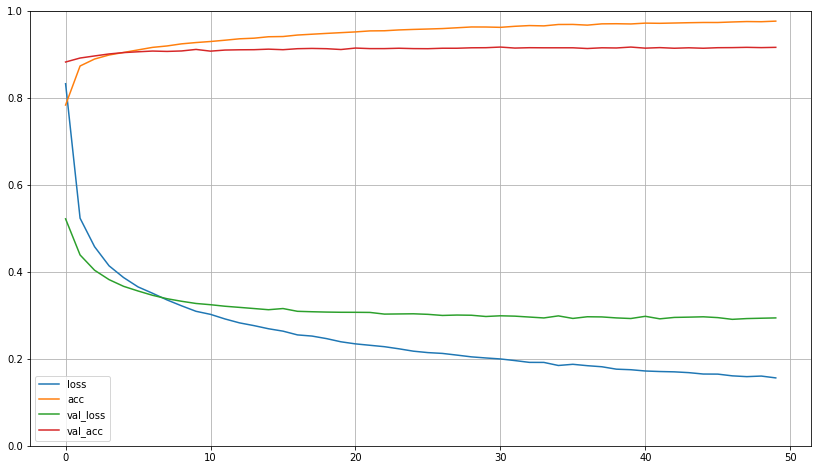

In [32]:
pd.DataFrame(history.history).plot(figsize=(14,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.savefig('savefig_500dpi.png', dpi=500)

In [28]:
 y_proba = cnn.predict(X_test_padded)
print("probability")
print(y_proba.round(3))

class_names = cat_encoder.categories_[0]
y_pred = np.argmax(y_proba,axis=1)
print()
print("predict")
print(class_names[y_pred])
print()
print("감정 개수 별 예측")
print(Counter(class_names[y_pred]))

probability
[[0.001 0.001 0.998 0.    0.    0.   ]
 [0.999 0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.   ]
 ...
 [0.    0.    0.    0.    1.    0.   ]
 [0.    1.    0.    0.    0.    0.   ]
 [0.116 0.068 0.12  0.536 0.052 0.108]]

predict
['fear' 'angry' 'disgust' ... 'sad' 'disgust' 'happy']

감정 개수 별 예측
Counter({'disgust': 851, 'happy': 841, 'surprised': 800, 'sad': 774, 'fear': 770, 'angry': 764})


---

## 모델 저장

In [33]:
from keras.models import load_model
import os

In [34]:
SAVE_MODEL_PATH = "/content/drive/MyDrive/Dataset 및 Project 정리/daum news and comments (2016 - 2017)/model/20210510 textcnn (epoch 50)"
SAVE_WEIGHT_PATH = "/content/drive/MyDrive/Dataset 및 Project 정리/daum news and comments (2016 - 2017)/model/20210510 textcnn (epoch 50)/check_point"

In [35]:
cnn.save(SAVE_MODEL_PATH)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dataset 및 Project 정리/daum news and comments (2016 - 2017)/model/20210510 textcnn (epoch 50)/assets


In [36]:
# 가중치를 저장합니다
cnn.save_weights(SAVE_WEIGHT_PATH)

In [43]:
SAVE_TOKENIZER = "/content/drive/MyDrive/Dataset 및 Project 정리/daum news and comments (2016 - 2017)/model/20210510 textcnn (epoch 50)/tokenizer"

In [44]:
import pickle

# save
with open(SAVE_TOKENIZER, 'wb') as f:
    pickle.dump(tokenizer, f, pickle.HIGHEST_PROTOCOL)

# # load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# 모델 불러오기

In [ ]:
new_model = tf.keras.models.load_model(SAVE_MODEL_PATH)

In [ ]:
FC_DATA_PATH = "/content/drive/MyDrive/2020/Lab/Project/[2020.01~] FactCheck News/Data/Result_ver2/00 tokenized/comments_tokenized_wo_exception_emotion (332690) v3.pkl"

In [ ]:
fc_data = pd.read_pickle(FC_DATA_PATH)
comment_token_list = fc_data["tk_cmts"].tolist()

In [ ]:
fc_comments_sequence = tokenizer.texts_to_sequences(comment_token_list)
fc_padded = pad_sequences(fc_comments_padded, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
y_proba = new_model.predict(fc_padded[:20])
print("probability")
print(y_proba.round(2))

class_names = cat_encoder.categories_[0]
y_pred = np.argmax(y_proba,axis=1)
print()
print("predict")
print(class_names[y_pred])

probability
[[0.2  0.11 0.08 0.23 0.25 0.13]
 [0.16 0.18 0.15 0.19 0.09 0.23]
 [0.99 0.   0.   0.   0.   0.  ]
 [0.51 0.11 0.06 0.11 0.13 0.07]
 [0.29 0.4  0.03 0.12 0.04 0.11]
 [0.62 0.03 0.02 0.11 0.18 0.04]
 [0.49 0.1  0.04 0.12 0.15 0.1 ]
 [0.28 0.08 0.07 0.32 0.18 0.06]
 [0.19 0.05 0.07 0.45 0.12 0.12]
 [0.   0.   1.   0.   0.   0.  ]
 [0.34 0.12 0.04 0.33 0.04 0.12]
 [0.33 0.27 0.06 0.13 0.1  0.12]
 [0.11 0.1  0.22 0.11 0.18 0.28]
 [1.   0.   0.   0.   0.   0.  ]
 [0.21 0.1  0.17 0.13 0.08 0.3 ]
 [0.29 0.21 0.08 0.19 0.16 0.07]
 [0.14 0.1  0.07 0.07 0.07 0.55]
 [0.   0.   0.   1.   0.   0.  ]
 [0.15 0.05 0.1  0.09 0.13 0.48]
 [0.18 0.1  0.11 0.42 0.09 0.11]]

predict
['sad' 'surprised' 'angry' 'angry' 'disgust' 'angry' 'angry' 'happy'
 'happy' 'fear' 'angry' 'angry' 'surprised' 'angry' 'surprised' 'angry'
 'surprised' 'happy' 'surprised' 'happy']
